# Examples of Holoviews

## Conditional Distributions

The following was an example provided on Holoviews website.


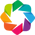

In [1]:
import numpy as np
import holoviews as hv
from holoviews import streams
hv.extension('bokeh')

In [19]:
%%opts Histogram {+framewise +axiswise}


# Declare distribution of Points
points = hv.Points(np.random.multivariate_normal((0, 0), [[1, 0.1], [0.1, 1]], (1000,)))

# Declare points selection selection
sel = streams.Selection1D(source=points)

# Declare DynamicMap computing mean y-value of selection
mean_sel = hv.DynamicMap(lambda index: hv.HLine(points['y'][index].mean() if index else -10),
                         kdims=[], streams=[sel])

# Declare a Bounds stream and DynamicMap to get box_select geometry and draw it
box = streams.Bounds(source=points, bounds=(0,0,0,0))
bounds = hv.DynamicMap(lambda bounds: hv.Bounds(bounds), streams=[box])

# Declare DynamicMap to apply bounds selection
dmap = hv.DynamicMap(lambda bounds: points.select(x=(bounds[0], bounds[2]),
                                                  y=(bounds[1], bounds[3])),
                     streams=[box])

# Compute histograms of selection along x-axis and y-axis
yhist = hv.operation.histogram(dmap, bin_range=points.range('y'), dimension='y', dynamic=True, normed=False)
xhist = hv.operation.histogram(dmap, bin_range=points.range('x'), dimension='x', dynamic=True, normed=False)

# Combine components and display
points * mean_sel * bounds << yhist << xhist

:AdjointLayout
   :DynamicMap   []
   :DynamicMap   []
   :DynamicMap   []

Possible improvments to the example

* Bins are fixed, should be made dynamic and maybe rescaling?
* Moving around with the data, the histograms don't really line up very well.

In [20]:
%%opts Distribution {+framewise}
renderer = hv.renderer('bokeh')
hv.opts("Points [tools=['box_select']]")

# Data Again
data = np.random.multivariate_normal((0, 0), [[1, 0.1], [0.1, 1]], (1000,))
points = hv.Points(data)

# How to make the selection, and from where
sel = streams.Selection1D(source=points)

# Make the distribution plots
def xdis(index):
    selected = points.iloc[index]
    dist = hv.Distribution(selected)
    return dist

# Make distribution plots
def ydis(index):
    selected = points.iloc[index]
    dist = hv.Distribution(selected, kdims=['y'])
    return dist

# Create the Dynamic Maps for X and Y
xconditional = hv.DynamicMap(xdis, streams=[sel])
yconditional = hv.DynamicMap(ydis, streams=[sel])

points << yconditional << xconditional

:AdjointLayout
   :Points   [x,y]
   :DynamicMap   []
   :DynamicMap   []

# Interactivity with Heatmap

In [3]:
%%opts Points [tools=['box_select']], Distribution {+framewise}

data = np.random.multivariate_normal((0, 0), [[1, 0.1], [0.1, 1]], (1000,))
points = hv.Points(data)

sel = streams.Selection1D(source=points)

def xdis(index):
    selected = points.iloc[index]
    dist = hv.Distribution(selected)
    return dist

def ydis(index):
    selected = points.iloc[index]
    dist = hv.Distribution(selected, kdims=['y'])
    return dist

def hmap(n):
    ht, xt, yt = np.histogram2d(data[:,0], data[:,1], n)
    return(hv.QuadMesh((xt, yt, ht)))

heatmap = hv.DynamicMap(hmap, kdims=['n']).redim.range(n=(5,40))
xconditional = hv.DynamicMap(xdis, streams=[sel])
yconditional = hv.DynamicMap(ydis, streams=[sel])

points * heatmap << xconditional << yconditional

UsageError: Cell magic `%%opts` not found.



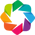

:HoloMap   [Default]
   :HexBins   [x,y]
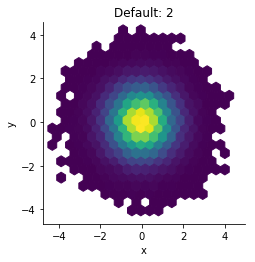
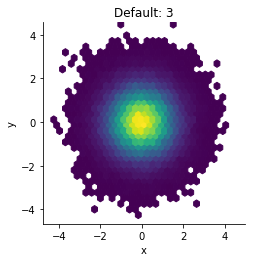
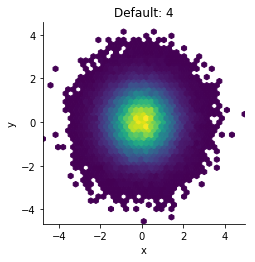
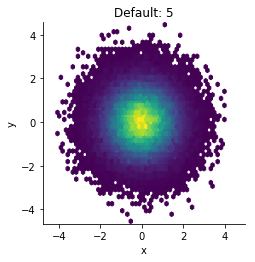
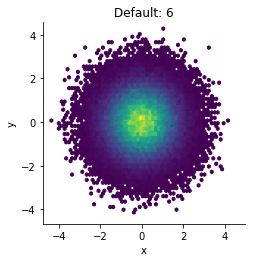
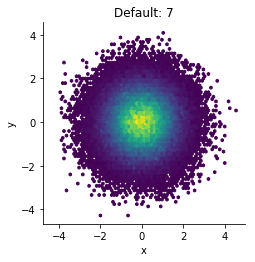
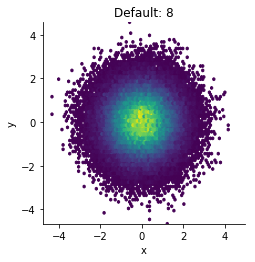
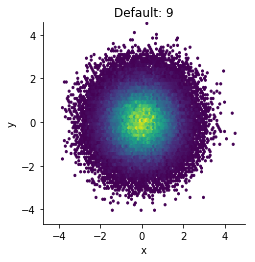

In [23]:
import param
import holoviews as hv
import numpy as np

from holoviews import Dimension
from holoviews.plotting.mpl import ElementPlot, ColorbarPlot

hv.notebook_extension('matplotlib', 'bokeh')

%output backend='matplotlib'

class HexBins(hv.Points):
    
    kdims = param.List([Dimension('x'), Dimension('y')],
                       bounds=(2, 2))
    
    group = param.String(default='HexBins')
    
class HexBinPlot(ColorbarPlot):

    agg_func = param.Callable(default=np.sum)
    
    gridsize = param.Integer(default=50)

    style_opts = ['edgecolors', 'alpha', 'linewidths', 'marginals']

    _plot_methods = dict(single='hexbin')

    def get_data(self, element, ranges, style):
        if not element.vdims:
            element = element.add_dimension('z', 0, np.ones(len(element)), True)
        xs, ys = (element.dimension_values(i) for i in range(2))
        args = (ys, xs) if self.invert_axes else (xs, ys)
        args += (element.dimension_values(2),)

        cdim = element.vdims[0]
        self._norm_kwargs(element, ranges, style, cdim)
        style['reduce_C_function'] = self.agg_func
        style['vmin'], style['vmax'] = cdim.range
        style['xscale'] = 'log' if self.logx else 'linear'
        style['yscale'] = 'log' if self.logy else 'linear'
        style['gridsize'] = self.gridsize
        return args, style, {}

hv.Store.register({HexBins: HexBinPlot}, 'matplotlib')
hv.HoloMap({i: HexBins(np.random.randn(100000,3))(plot=dict(gridsize=i*10)) for i in range(2,10)})

In [2]:
%%opts Points [tools=['box_select']] Points {+framewise}
import param
import paramnb

data = np.random.multivariate_normal((0, 0), [[1, 0.1], [0.1, 1]], (1000,))
points = hv.Points(data)

def hmap(n):
    ht, xt, yt = np.histogram2d(data[:,0], data[:,1], n)
    return(hv.QuadMesh((xt, yt, ht)))

class ScatterHeat(hv.streams.Stream):
    sel = streams.Selection1D(source=points)
    
    n = param.Integer(default=10, bounds=(5, 40))

    def view(self):
        heatmap = hv.DynamicMap(hmap, kdims=[], streams=[self])
        return points * heatmap

def render(obj):
    renderer = hv.renderer('bokeh')
    plot = renderer.get_plot(obj)
    size = renderer.get_size(plot)
    return renderer._figure_data(plot), size

explorer = ScatterHeat()
paramnb.Widgets(explorer, continuous_update=True, callback=explorer.event, on_init=True)
explorer.view()

<IPython.core.display.Javascript object>

VBox(children=(HTML(value='\n        <style>\n          .ttip { position: relative; display: inline-block; }\n          .ttip .ttiptext { visibility: hidden; background-color: #F8F8F8; outline: #CCCCCC solid thin;\n             color: black; border-radius: 2px; padding: 2px; text-align: center;\n             position: absolute; left: 53%; top: 30px; box-shadow: 7px 7px 10px #DDDDDD;\n             z-index: 100; min-width: 100px; font-size: 80%}\n          .ttip:hover .ttiptext { visibility: visible; }\n          .widget-dropdown .dropdown-menu { width: 100% }\n          .widget-select-multiple select { min-height: 100px; min-width: 300px;}\n        </style>\n        <div class="ttip"><b>ScatterHeat01299</b></div>'), HBox(children=(HTML(value='<div class="ttip" style="padding: 5px; width: 60px;\n                      text-align: right;">n</div>'), IntSlider(value=10, max=40, min=5)))), layout=Layout(display='flex', flex_flow='column'))

:DynamicMap   []